In [1]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Datasets/2transfers_rund_10-90.csv', low_memory = False)

In [2]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [25, 24]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [4]:
#bins amount
#transfers: 1M - 35.8775 / 2M - 37.3285 / 3M - 38.2194 / 4M - 38.818 / 5M - 39.3326 / gans - 26.3159 / imbalanced - 24.7233
#payments: 1M - 36.7452 / 2M - 38.2134 / 3M - 39.1709 / 4M - 39.8368 / 5M - 40.2234 / gans - 24.8089 / imbalanced - 22.5533

#bins accountbalance
#transfers: 1M - 37.0555 / 2M - 38.5003 / 3M - 39.4439 / 4M - 40.1224 / 5M - 40.627 / gans - 25.734 / imbalanced - 23.9742
#payments: 1M - 37.234 / 2M - 38.6645 / 3M - 39.651 / 4M - 40.2506 / 5M - 40.7402 / gans - 26.0935 / imbalanced - 20.7986

In [3]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [6]:
#interval that a word corresponds to
#values_map['red']

In [4]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [5]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [6]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [7]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [8]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [9]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [10]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [11]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [12]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [13]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [14]:
#get size of the corpus 
token_count = sum([len(sentence) for sentence in sentences_series])

print("This corpus contains {} tokens".format(token_count))

This corpus contains 83239 tokens


In [14]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences, cycles, dim, window, sample, negative, exponent, alpha, min_alpha):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = dim,  #dimension of the embedding space 
        window = window,  #words befores and after the center word 
        sample = sample,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = negative,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = exponent,  #exponent to shape negative sampling 
        alpha = alpha,  #initial learning rate 
        min_alpha = min_alpha,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = cycles, total_examples = model.corpus_count, compute_loss = True, callbacks = [])

    return model

In [14]:
#inicialization, training and creation after grid-search chosen hyperparameters - do not run the first training in running this
import multiprocessing
import gensim.models.word2vec as w2v

def training(sentences):
    model = w2v.Word2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = 2,  #dimension of the embedding space - muda
        window = 1,  #words befores and after the center word - muda
        sample = 0.001,  #whithout subsampling - muda 
        min_count = 1,  #use every word 
        negative = 10,  #noise-words - muda
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = 0.035,  #initial learning rate - muda
        min_alpha = 0.001,  #final learning rate - muda
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training 
    model.train(sentences, epochs = 5, total_examples = model.corpus_count, compute_loss = True, callbacks = [])

    return model

#model creation
model = training(sentences_series)

In [24]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#begin of test - 1st step
begin = time.time()

In [15]:
#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1
    
    return 0

In [16]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)

    return predictions

In [17]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [18]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [ ]:
#grid-search
import os
from mlflow import log_metric, log_param, log_artifact
import mlflow
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef

#create a hyperparameters dictionary 
dim = [2, 5, 35, 50, 100, 300]  
cycles = [5, 10, 15, 20, 50] 
window = range(1, 9, 1)  
negative = range(5, 20, 5) #0 leads to not having the syn1neg property
exponent =  [0, 0.75, 1] 
alpha = [0.015, 0.025, 0.035] 
min_alpha = [0.00001, 0.0001, 0.001]  
sample = [0, 0.0001, 0.001, 0.01]

#train the model 
i = 0
for c in cycles:
    for d in dim:
        for w in window:
            for n in negative:
                for e in exponent:
                    for a in alpha:
                        for m in min_alpha:
                            for s in sample:

                                    i+=1
                                    with mlflow.start_run(nested=True):

                                        # Log params to mlflow
                                        log_param("cycles", c)
                                        log_param("dim", d)
                                        log_param("window", w)
                                        log_param("negative", n)
                                        log_param("exponent", e)
                                        log_param("alpha", a)
                                        log_param("min_alpha", m)
                                        log_param("sample", s)

                                        curr_model = training(sentences_series_np_train, cycles = c, dim = d, window = w, 
                                                              sample = s, negative = n, exponent = e, alpha = a, min_alpha = m)
                                    
                                        #metrics for each combination - train
                                        prevs_train = predict(curr_model, sentences_series_np_train, verbose1 = False, verbose2 = False)
                                        precision_train, recall_train, fscore_train, _ = precision_recall_fscore_support(y_train, prevs_train, average='micro')
                                        mcc_train = matthews_corrcoef(y_train, prevs_train)
                                        log_param("accuracy_train", accuracy_score(y_train, prevs_train))
                                        log_param("precision_train", precision_train)
                                        log_param("recall_train", recall_train)
                                        log_param("f1_train", fscore_train)
                                        log_param("mcc_train", mcc_train)
                                        
                                        #metrics for each combination - test
                                        prevs_test = predict(curr_model, sentences_series_np_test, verbose1 = False, verbose2 = False)
                                        precision_test, recall_test, fscore_test, _ = precision_recall_fscore_support(y_test, prevs_test, average='micro')
                                        mcc_test = matthews_corrcoef(y_test, prevs_test)
                                        log_param("accuracy_test", accuracy_score(y_test, prevs_test))
                                        log_param("precision_test", precision_test)
                                        log_param("recall_test", recall_test)
                                        log_param("f1_test", fscore_test)
                                        log_param("mcc_test", mcc_test)
                                        

                                        curr_model.save("trained_model.w2v")
                                        log_artifact("trained_model.w2v")
                                        os.remove("trained_model.w2v")

Validation loss decreased (inf --> 135174.390625).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 43587.574219).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 83084.351562).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 63761.617188).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 133924.031250).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out

EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 135864.937500).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 43386.300781).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 38222.093750).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 60703.367188).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 136349.031250).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out

Validation loss decreased (inf --> 53639.937500).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 20712.447266).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 31851.181641).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 50986.871094).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 111822.695312).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out 

EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 57643.093750).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 79672.625000).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 76065.492188).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 53939.054688).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 161896.734375).  Saving model ...
EarlyStopping counter: 1 out 

Validation loss decreased (inf --> 73404.796875).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 187171.656250).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 36697.214844).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 59044.156250).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 75667.289062).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out 

Validation loss decreased (inf --> 75111.632812).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 76650.453125).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 67717.226562).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 49367.250000).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 75186.859375).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out o

EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 205714.593750).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 64084.691406).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 57407.949219).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 68239.304688).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Validation loss decreased (inf --> 64675.816406).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out 

In [ ]:
#apply the prediction method for the train set
#predict(model, X_train_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values for the train set
#y_train

In [ ]:
#metrics for the train set
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_train
prevs = predict(model, X_train_np.values, verbose1 = False, verbose2 = False, shouldBe = trs)

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs,prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

#precision-recall curve - compute precision-recall pairs for different probability thresholds
print(precision_recall_curve(trs, prevs))

In [ ]:
#apply the prediction method for the test set
#predict(model, X_test_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values of the test set
#set(y_test)

In [ ]:
#metrics for the test set 
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_test
prevs = predict(model, X_test_np.values, verbose1 = False, verbose2 = True)

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs, prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))


print(precision_recall_curve(trs, prevs))

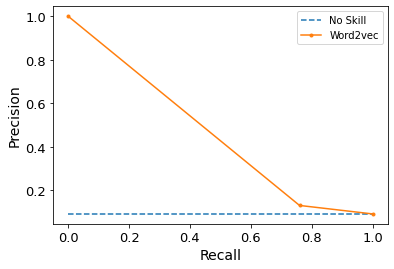

In [35]:
#precision-recall curve - compute precision-recall pairs for different probability thresholds
from matplotlib import pyplot

precision, recall, thresholds = precision_recall_curve(trs, prevs)

no_skill = trs.count(1) / len(trs)

#no-skill classifier
pyplot.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')

#word2vec classifier
pyplot.plot(recall, precision, marker = '.', label = 'Word2vec')

#labels
pyplot.xlabel('Recall', fontsize = 14)
pyplot.ylabel('Precision', fontsize = 14)

#ticks
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

#legend
pyplot.legend()

#save
plt.savefig(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Profiles/prcurve_transfers.png')

pyplot.show()